# Full observation settings

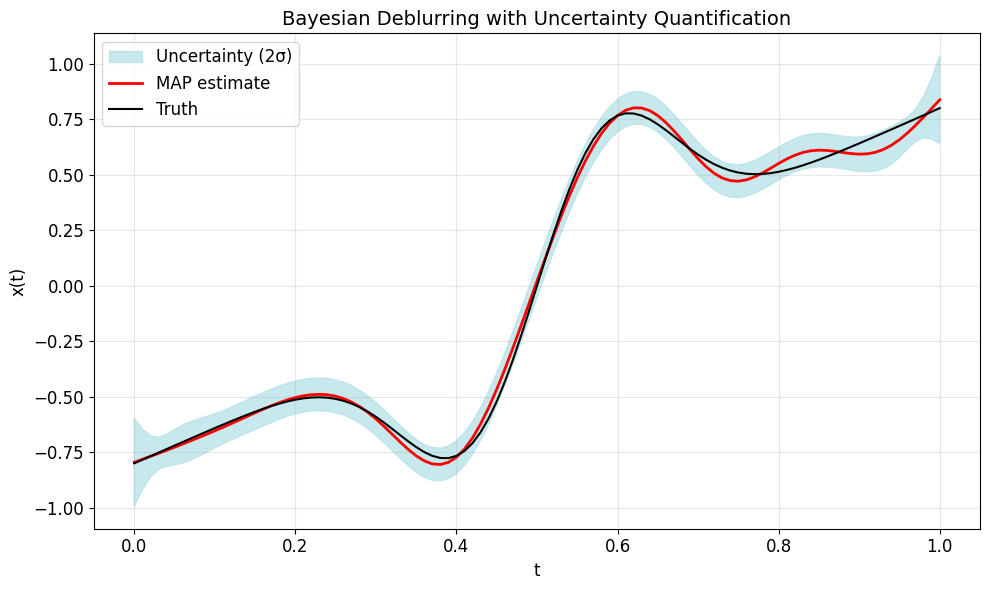

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, inv
import matplotlib.patches as patches
np.random.seed(20)

def plot_results(t, xmean, xtrue, Gamma_post, n):
    """Plot the MAP estimate with uncertainty bounds"""
    
    # Different shades of blue for plotting
    shades = np.array([
        [176, 224, 230],
        [135, 206, 235], 
        [135, 206, 255],
        [126, 192, 238],
        [108, 166, 205]
    ]) / 255
    
    STD = np.sqrt(np.diag(Gamma_post))
    xhigh = xmean + 2*STD
    xlow = xmean - 2*STD
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.tick_params(labelsize=12)
    
    # Fill the uncertainty region
    t_fill = np.concatenate([t, t[::-1]])
    x_fill = np.concatenate([xlow, xhigh[::-1]])
    plt.fill(t_fill, x_fill, color=shades[0], alpha=0.7, label='Uncertainty (2σ)')
    
    # Plot the lines
    plt.plot(t, xmean, 'r-', linewidth=2, label='MAP estimate')
    plt.plot(t, xtrue, 'k-', linewidth=1.5, label='Truth')
    
    plt.legend(loc='best', fontsize=12)
    plt.xlabel('t', fontsize=12)
    plt.ylabel('x(t)', fontsize=12)
    plt.title('Bayesian Deblurring with Uncertainty Quantification', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



# Mesh
n = 100
s = np.linspace(0, 1, n+1)
t = s.copy()

# Prior flag
PriorFlag = 2  # 1: L_D, 2: L_A

# Discretize the deblurring kernel
beta = 0.05
a = (1/np.sqrt(2*np.pi*beta**2)) * np.exp(-0.5*(1/beta**2)*t**2)
A = (1/n) * toeplitz(a)

# Truth
xtrue = 10*(t-0.5)*np.exp(-0.5*1e2*(t-0.5)**2) - 0.8 + 1.6*t

# Additive noise
noise = 5  # Noise level in percentages of the max. of noiseless signal
y0 = A @ xtrue  # Noiseless signal
sigma = np.max(np.abs(y0)) * noise / 100  # STD of the additive noise
y = y0 + sigma * np.random.randn(n+1)

# Prior construction
# Standard deviation of the innovation
gamma = 1/n

# Construct the L matrix based on PriorFlag
if PriorFlag == 1:
    L = (np.diag(np.ones(n+1)) - 
            np.diag(0.5*np.ones(n), 1) - 
            np.diag(0.5*np.ones(n), -1))
elif PriorFlag == 2:
    L_D = (np.diag(np.ones(n+1)) - 
            np.diag(0.5*np.ones(n), 1) - 
            np.diag(0.5*np.ones(n), -1))
    
    # Note: you should never do this, but we do it anyway for convenience
    L_Dinv = inv(L_D)
    Dev = np.sqrt(gamma**2 * np.diag(L_Dinv @ L_Dinv.T))
    
    delta = gamma / Dev[n//2]
    L = L_D.copy()
    L[0, :] = 0
    L[0, 0] = delta
    L[-1, :] = 0
    L[-1, -1] = delta
else:
    raise ValueError('PriorFlag not supported')

# Calculate the MAP estimate and posterior variances by least squares
# Solve the augmented system
A_aug = np.vstack([(1/sigma)*A, (1/gamma)*L])
b_aug = np.concatenate([(1/sigma)*y, np.zeros(n+1)])

xmean = np.linalg.lstsq(A_aug, b_aug, rcond=None)[0]

# Posterior covariance
Gamma_post = inv((1/sigma**2)*A.T @ A + (1/gamma**2)*L.T @ L)

# Plot the MAP estimate and the 2*STD envelope
plot_results(t, xmean, xtrue, Gamma_post, n)

# Sparse observation settings for linear forward models


# Bayesian Framework for Deblurring Problems

## Problem Formulation

Consider the inverse problem of reconstructing a signal $x(t)$ from noisy, blurred observations. The forward model relates the true signal to the observations through:

$$y = Ax + \epsilon$$

where:
- $y \in \mathbb{R}^{n_{obs}}$ are the noisy observations
- $x \in \mathbb{R}^{n+1}$ is the unknown signal to be reconstructed
- $A \in \mathbb{R}^{n_{obs} \times (n+1)}$ is the blurring operator (observation matrix)
- $\epsilon \sim \mathcal{N}(0, \sigma^2 I)$ is additive Gaussian noise

## Forward Model: Blurring Operator

The blurring operator is constructed as a Toeplitz matrix based on a Gaussian kernel:

$$a(t) = \frac{1}{\sqrt{2\pi\beta^2}} \exp\left(-\frac{t^2}{2\beta^2}\right)$$

where $\beta$ controls the blur width. The matrix $A$ is formed as:

$$A = \frac{1}{n} \text{toeplitz}(a)$$

For sparse observations, we select only specific rows of this matrix corresponding to observation locations.

## Bayesian Framework

### Likelihood Model

Given the additive Gaussian noise assumption, the likelihood follows:

$$p(y|x) = \mathcal{N}(Ax, \sigma^2 I)$$

The log-likelihood is:
$$\log p(y|x) = -\frac{1}{2\sigma^2}\|y - Ax\|^2 + \text{const}$$

### Prior Model

We impose smoothness constraints on the signal through a Gaussian prior:

$$p(x) = \mathcal{N}(0, \gamma^2 (L^T L)^{-1})$$

where $L$ is a regularization matrix and $\gamma$ controls the prior strength.

#### Prior Matrix Construction

Two types of priors are implemented:

**Type 1 ($L_D$)**: Simple difference operator
$$L = I - \frac{1}{2}(E_+ + E_-)$$

where $E_+$ and $E_-$ are forward and backward shift operators.

**Type 2 ($L_A$)**: Modified difference operator with boundary conditions
$$L = L_D \text{ with modified boundary rows}$$
$$L[0,:] = 0, \quad L[0,0] = \delta$$
$$L[n,:] = 0, \quad L[n,n] = \delta$$

where $\delta = \gamma / \text{Dev}[n/2]$ and $\text{Dev}$ accounts for the variance structure.

## Posterior Distribution

By Bayes' theorem, the posterior distribution is:

$$p(x|y) \propto p(y|x) p(x)$$

Since both likelihood and prior are Gaussian, the posterior is also Gaussian:

$$p(x|y) = \mathcal{N}(x_{MAP}, \Gamma_{post})$$

### Maximum A Posteriori (MAP) Estimate

The MAP estimate minimizes the negative log-posterior:

$$x_{MAP} = \arg\min_x \left\{ \frac{1}{2\sigma^2}\|y - Ax\|^2 + \frac{1}{2\gamma^2}\|Lx\|^2 \right\}$$

This leads to the normal equations:
$$\left(\frac{1}{\sigma^2}A^T A + \frac{1}{\gamma^2}L^T L\right) x_{MAP} = \frac{1}{\sigma^2}A^T y$$

### Posterior Covariance

The posterior covariance matrix is:
$$\Gamma_{post} = \left(\frac{1}{\sigma^2}A^T A + \frac{1}{\gamma^2}L^T L\right)^{-1}$$

The diagonal elements give pointwise variances:
$$\text{Var}[x_i|y] = [\Gamma_{post}]_{ii}$$

## Computational Implementation

### Augmented System Approach

Instead of solving the normal equations directly, we solve the augmented least squares problem:

$$\min_x \left\| \begin{pmatrix} \frac{1}{\sigma}A \\ \frac{1}{\gamma}L \end{pmatrix} x - \begin{pmatrix} \frac{1}{\sigma}y \\ 0 \end{pmatrix} \right\|^2$$

This approach is numerically more stable and avoids explicit computation of $A^T A$.

### Uncertainty Quantification

The $2\sigma$ confidence bands are computed as:
$$x_{MAP} \pm 2\sqrt{\text{diag}(\Gamma_{post})}$$

These bands represent approximate 95% credible intervals for the reconstructed signal.

## Key Parameters

- **$\beta$**: Blur kernel width (controls blurring severity)
- **$\sigma$**: Noise standard deviation (estimated from data)
- **$\gamma$**: Prior strength parameter (controls smoothness)
- **$n_{obs}$**: Number of observation points (affects uncertainty)

## Interpretation

- **Sparse observations**: Fewer observation points lead to larger uncertainties
- **Prior strength**: Stronger priors (smaller $\gamma$) enforce more smoothness
- **Noise level**: Higher noise increases posterior uncertainty
- **Observation locations**: Uncertainty is typically larger in regions far from observations

This Bayesian framework provides both point estimates (MAP) and uncertainty quantification, making it particularly valuable for inverse problems where understanding reconstruction reliability is crucial.

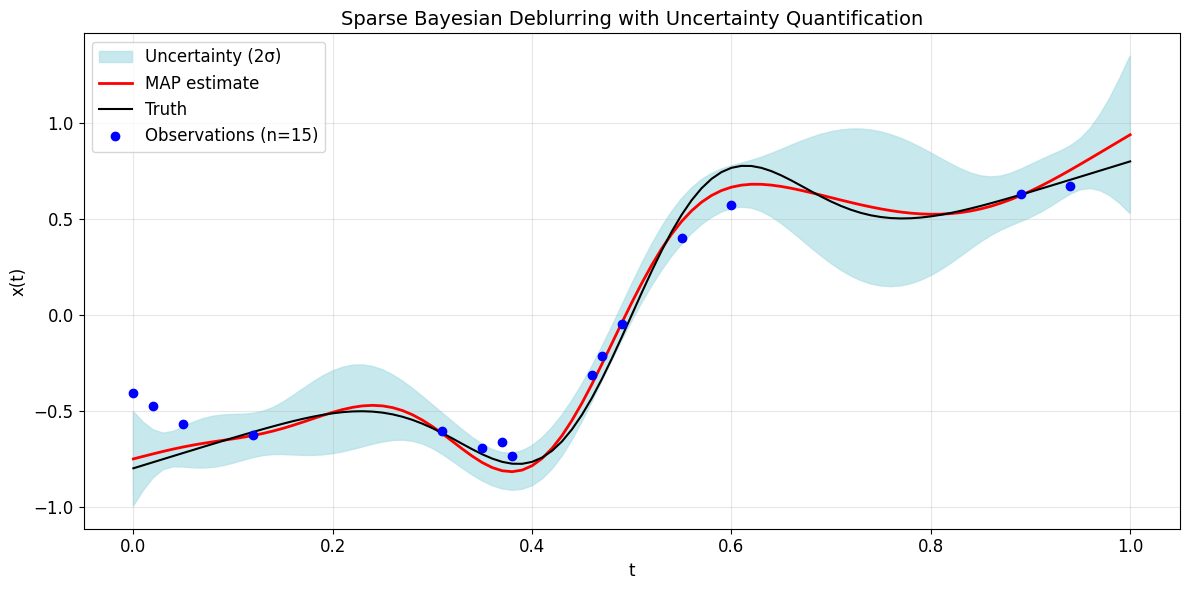

Number of observations: 15
Observation locations: [ 0  2  5 12 31 35 37 38 46 47 49 55 60 89 94]
Noise level: 5%
Prior type: L_A


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, inv
import matplotlib.patches as patches

np.random.seed(20)

def plot_results(t, xmean, xtrue, Gamma_post, n, t_obs, y_obs):
    """Plot the MAP estimate with uncertainty bounds and observation points"""
    
    # Different shades of blue for plotting
    shades = np.array([
        [176, 224, 230],
        [135, 206, 235], 
        [135, 206, 255],
        [126, 192, 238],
        [108, 166, 205]
    ]) / 255
    
    STD = np.sqrt(np.diag(Gamma_post))
    xhigh = xmean + 2*STD
    xlow = xmean - 2*STD
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    ax.tick_params(labelsize=12)
    
    # Fill the uncertainty region
    t_fill = np.concatenate([t, t[::-1]])
    x_fill = np.concatenate([xlow, xhigh[::-1]])
    plt.fill(t_fill, x_fill, color=shades[0], alpha=0.7, label='Uncertainty (2σ)')
    
    # Plot the lines
    plt.plot(t, xmean, 'r-', linewidth=2, label='MAP estimate')
    plt.plot(t, xtrue, 'k-', linewidth=1.5, label='Truth')
    
    # Plot observation points
    plt.plot(t_obs, y_obs, 'bo', markersize=6, label=f'Observations (n={len(t_obs)})')
    
    plt.legend(loc='best', fontsize=12)
    plt.xlabel('t', fontsize=12)
    plt.ylabel('x(t)', fontsize=12)
    plt.title('Sparse Bayesian Deblurring with Uncertainty Quantification', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Mesh
n = 100
s = np.linspace(0, 1, n+1)
t = s.copy()

# Sparse observation settings
n_obs = 15  # Number of observation points
# Select observation indices (you can change this strategy)
# obs_indices = np.linspace(0, n, n_obs, dtype=int)  # Evenly spaced
# Alternative: 
# obs_indices = np.random.choice(n+1, n_obs, replace=False)  # Random
# Alternative: 
obs_indices = np.sort(np.random.choice(n+1, n_obs, replace=False))  # Random but sorted

t_obs = t[obs_indices]

# Prior flag
PriorFlag = 2  # 1: L_D, 2: L_A

# Discretize the deblurring kernel
beta = 0.05
a = (1/np.sqrt(2*np.pi*beta**2)) * np.exp(-0.5*(1/beta**2)*t**2)
A_full = (1/n) * toeplitz(a)

# Create sparse observation matrix (select only observed rows)
A = A_full[obs_indices, :]

# Truth
xtrue = 10*(t-0.5)*np.exp(-0.5*1e2*(t-0.5)**2) - 0.8 + 1.6*t

# Additive noise
noise = 5  # Noise level in percentages of the max. of noiseless signal
y0_full = A_full @ xtrue  # Full noiseless signal
y0 = y0_full[obs_indices]  # Noiseless signal at observation points
sigma = np.max(np.abs(y0_full)) * noise / 100  # STD of the additive noise
y_obs = y0 + sigma * np.random.randn(n_obs)  # Noisy observations

# Prior construction
# Standard deviation of the innovation
gamma = 1/n

# Construct the L matrix based on PriorFlag
if PriorFlag == 1:
    L = (np.diag(np.ones(n+1)) - 
            np.diag(0.5*np.ones(n), 1) - 
            np.diag(0.5*np.ones(n), -1))
elif PriorFlag == 2:
    L_D = (np.diag(np.ones(n+1)) - 
            np.diag(0.5*np.ones(n), 1) - 
            np.diag(0.5*np.ones(n), -1))
    
    # Note: you should never do this, but we do it anyway for convenience
    L_Dinv = inv(L_D)
    Dev = np.sqrt(gamma**2 * np.diag(L_Dinv @ L_Dinv.T))
    
    delta = gamma / Dev[n//2]
    L = L_D.copy()
    L[0, :] = 0
    L[0, 0] = delta
    L[-1, :] = 0
    L[-1, -1] = delta
else:
    raise ValueError('PriorFlag not supported')

# Calculate the MAP estimate and posterior variances by least squares
# Solve the augmented system (now with sparse observations)
A_aug = np.vstack([(1/sigma)*A, (1/gamma)*L])
b_aug = np.concatenate([(1/sigma)*y_obs, np.zeros(n+1)])

xmean = np.linalg.lstsq(A_aug, b_aug, rcond=None)[0]

# Posterior covariance
Gamma_post = inv((1/sigma**2)*A.T @ A + (1/gamma**2)*L.T @ L)

# Plot the MAP estimate and the 2*STD envelope with observation points
plot_results(t, xmean, xtrue, Gamma_post, n, t_obs, y_obs)

print(f"Number of observations: {n_obs}")
print(f"Observation locations: {obs_indices}")
print(f"Noise level: {noise}%")
print(f"Prior type: {'L_D' if PriorFlag == 1 else 'L_A'}")

# Applying mcmc as non-linear forward models

Starting MCMC...
Average acceptance rate: 0.2390
Estimated mean: [-0.1798, 0.4880]


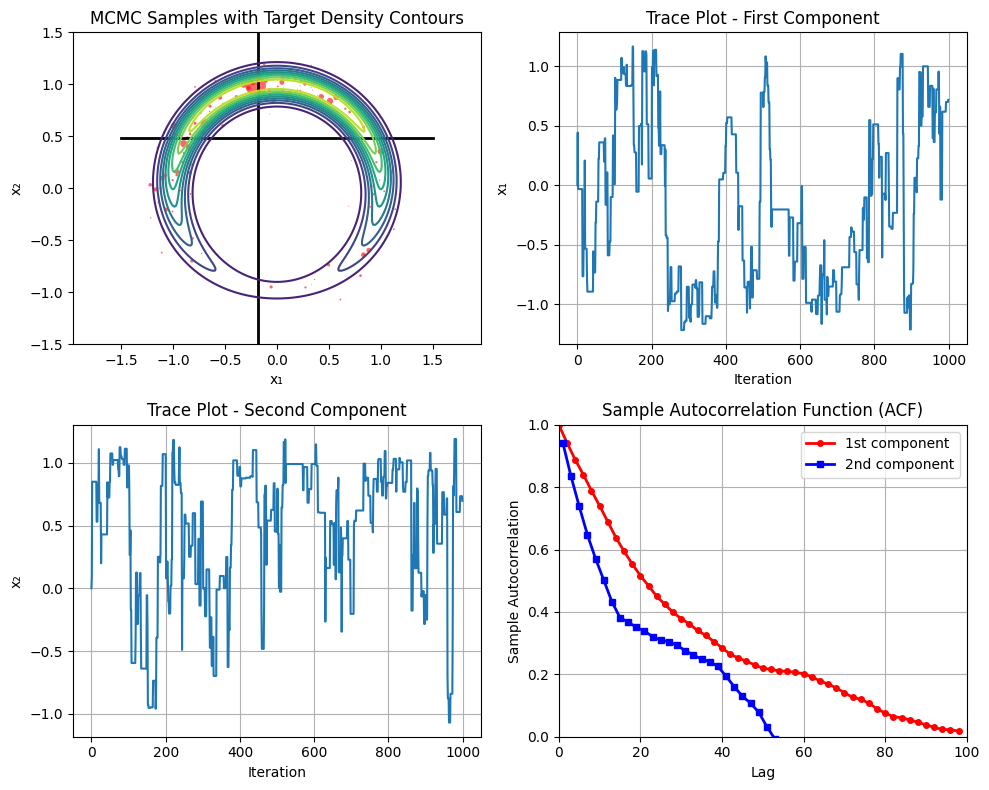

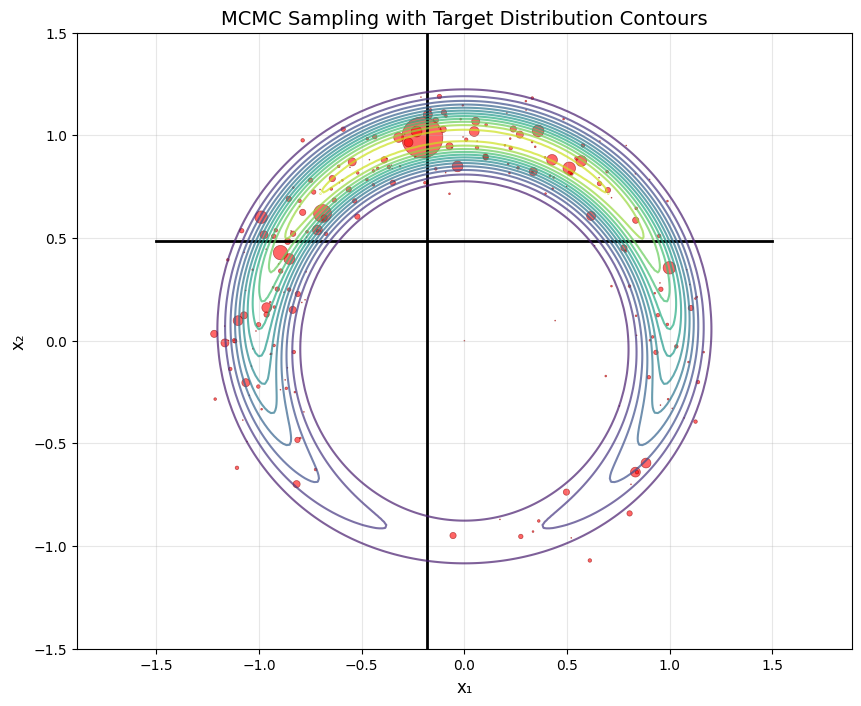

\nFinal results:
Number of unique sample points: 239
Total samples: 1000
Estimated mean: [-0.179806, 0.488028]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.patches as patches

# Set random seeds for reproducibility
np.random.seed(20)

def run_mcmc():
    """
    MCMC algorithms - Metropolis-Hastings
    Based on Tan Bui-Thanh's MATLAB code, April 2012
    Institute for computational engineering and sciences
    The University of Texas at Austin
    """
    
    # Number of samples
    N = 1000
    
    # Preallocate the sampling point array
    n = 2
    Sample = np.zeros((n, N))
    Samplew = []  # List to store [x, y, weight] for each unique point
    
    # Target density parameters
    sigma = 0.1
    delta = 1
    
    def Pi(m):
        """Target density function"""
        return np.exp(-0.5/sigma**2 * (np.sqrt(np.sum(m**2)) - 1)**2 - 0.5/delta**2 * (m[1] - 1)**2)
    
    # Proposal variance and density
    gamma = 0.5
    
    def q(m, p):
        """Proposal density (symmetric)"""
        return 1/np.sqrt(2*np.pi*gamma**2) * np.exp(-0.5/gamma**2 * np.sum((m-p)**2))
    
    def proposal(m):
        """Proposal function"""
        return m + gamma * np.random.randn(n)
    
    print('Starting MCMC...')
    
    # Value of pi at the sampling points
    Pisampling = np.zeros(N)
    
    # Initial sampling point at the origin
    m = np.array([0.0, 0.0])
    Samplew.append([m[0], m[1], 1])  # [x, y, weight]
    
    # Target density value of the initial point
    PisamplingOld = Pi(m)
    
    sample_count = 1  # Start from 1 since we already have the first sample
    
    # Metropolis-Hastings loop
    while sample_count < N:
        # Generate a new point from the current point from the proposal distribution
        p = proposal(m)
        
        # Compute the target density
        PisamplingNew = Pi(p)
        
        # Compute the proposal (symmetric, so qmp = qpm)
        qmp = q(m, p)
        qpm = q(p, m)
        
        # Compute the acceptance ratio, using log to avoid underflow and overflow
        if PisamplingOld * qmp > 0:  # Avoid log(0)
            alpha = np.log(PisamplingNew * qpm) - np.log(PisamplingOld * qmp)
        else:
            alpha = np.inf  # Force acceptance if denominator is 0
        
        if alpha > np.log(np.random.rand()):
            # Accept the new sampling point
            m = p
            PisamplingOld = PisamplingNew
            Samplew.append([m[0], m[1], 1])
        else:
            # Increase the weight if stay put
            Samplew[-1][2] += 1
        
        Sample[:, sample_count] = m
        sample_count += 1
    
    # Convert Samplew to numpy array for easier manipulation
    Samplew = np.array(Samplew).T  # Shape: (3, num_unique_points)
    
    # Average acceptance rate
    acceptance_rate = len(Samplew[0]) / N
    print(f'Average acceptance rate: {acceptance_rate:.4f}')
    
    # Estimated mean
    mbar = (Samplew[0:n, :] @ Samplew[2, :]) / N
    print(f'Estimated mean: [{mbar[0]:.4f}, {mbar[1]:.4f}]')
    
    return Sample, Samplew, mbar

def plot_mcmc_results(Sample, Samplew, mbar):
    """Plot MCMC results with contours and weighted samples"""
    
    # First plot: Contour plot with samples and mean
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 2, 1)
    
    # Plot mean lines
    plt.plot([-1.5, 1.5], [mbar[1], mbar[1]], 'k', linewidth=2, label='Sample mean')
    plt.plot([mbar[0], mbar[0]], [-1.5, 1.5], 'k', linewidth=2)
    
    # Create contour plot
    N_grid = 200
    x, y = np.meshgrid(np.linspace(-1.5, 1.5, N_grid), np.linspace(-1.5, 1.5, N_grid))
    
    # Target density parameters (same as in MCMC)
    sigma = 0.1
    delta = 1
    
    target = np.zeros((N_grid, N_grid))
    for i in range(N_grid):
        for j in range(N_grid):
            m = np.array([x[i, j], y[i, j]])
            target[i, j] = np.exp(-0.5/sigma**2 * (np.sqrt(np.sum(m**2)) - 1)**2 - 
                                 0.5/delta**2 * (m[1] - 1)**2)
    
    plt.contour(x, y, target, levels=10)
    
    # Plot circles at each unique point with radius proportional to staying time
    N_unique = Samplew.shape[1]
    t = np.linspace(0, 2*np.pi, 20)
    scale = 10 * np.max(Samplew[2, :])  # Find the scale
    
    for i in range(N_unique):
        r = Samplew[2, i] / scale
        circle_x = r * np.cos(t) + Samplew[0, i]
        circle_y = r * np.sin(t) + Samplew[1, i]
        plt.fill(circle_x, circle_y, 'r', alpha=0.6)
    
    plt.axis('equal')
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    plt.title('MCMC Samples with Target Density Contours')
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    
    # Second plot: Trace plot for first component
    plt.subplot(2, 2, 2)
    plt.plot(Sample[0, :])
    plt.title('Trace Plot - First Component')
    plt.xlabel('Iteration')
    plt.ylabel('x₁')
    plt.grid(True)
    
    # Third plot: Trace plot for second component
    plt.subplot(2, 2, 3)
    plt.plot(Sample[1, :])
    plt.title('Trace Plot - Second Component')
    plt.xlabel('Iteration')
    plt.ylabel('x₂')
    plt.grid(True)
    
    # Fourth plot: Sample autocorrelation function
    plt.subplot(2, 2, 4)
    
    # Compute correlation length
    N_samples = Sample.shape[1]
    Sample0 = Sample - np.mean(Sample, axis=1, keepdims=True)  # Zero mean
    maxLag = 99
    chat = np.zeros((2, maxLag + 1))
    
    for i in range(2):  # For each component
        c0 = np.dot(Sample0[i, :], Sample0[i, :])
        for k in range(maxLag + 1):
            if N_samples - k > 0:
                chat[i, k] = np.sum(Sample0[i, :N_samples-k] * Sample0[i, k:N_samples]) / c0
    
    # Plot autocorrelation
    lags = np.arange(maxLag + 1)
    odd = np.arange(0, maxLag + 1, 2)
    even = np.arange(1, maxLag + 1, 2)
    
    plt.plot(odd, chat[0, odd], 'r-o', linewidth=2, markersize=4, label='1st component')
    plt.plot(even, chat[1, even], 'b-s', linewidth=2, markersize=4, label='2nd component')
    
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.xlabel('Lag')
    plt.ylabel('Sample Autocorrelation')
    plt.title('Sample Autocorrelation Function (ACF)')
    plt.xlim([0, 100])
    plt.ylim([0, 1])
    
    plt.tight_layout()
    plt.show()

def plot_detailed_contour(Sample, Samplew, mbar):
    """Create a detailed contour plot similar to the original MATLAB version"""
    
    plt.figure(figsize=(10, 8))
    
    # Plot mean lines
    plt.plot([-1.5, 1.5], [mbar[1], mbar[1]], 'k', linewidth=2)
    plt.plot([mbar[0], mbar[0]], [-1.5, 1.5], 'k', linewidth=2)
    
    # Create finer contour plot
    N_grid = 200
    x, y = np.meshgrid(np.linspace(-1.5, 1.5, N_grid), np.linspace(-1.5, 1.5, N_grid))
    
    # Target density parameters
    sigma = 0.1
    delta = 1
    
    target = np.zeros((N_grid, N_grid))
    for i in range(N_grid):
        for j in range(N_grid):
            m = np.array([x[i, j], y[i, j]])
            target[i, j] = np.exp(-0.5/sigma**2 * (np.sqrt(np.sum(m**2)) - 1)**2 - 
                                 0.5/delta**2 * (m[1] - 1)**2)
    
    plt.contour(x, y, target, levels=15, alpha=0.7)
    
    # Plot circles at each unique point
    N_unique = Samplew.shape[1]
    t = np.linspace(0, 2*np.pi, 100)
    scale = 10 * np.max(Samplew[2, :])
    
    for i in range(N_unique):
        r = Samplew[2, i] / scale
        circle_x = r * np.cos(t) + Samplew[0, i]
        circle_y = r * np.sin(t) + Samplew[1, i]
        plt.fill(circle_x, circle_y, 'red', alpha=0.6, edgecolor='darkred', linewidth=0.5)
    
    plt.axis('equal')
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    plt.title('MCMC Sampling with Target Distribution Contours', fontsize=14)
    plt.xlabel('x₁', fontsize=12)
    plt.ylabel('x₂', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

# Run the MCMC algorithm
if __name__ == "__main__":
    Sample, Samplew, mbar = run_mcmc()
    
    # Create plots
    plot_mcmc_results(Sample, Samplew, mbar)
    plot_detailed_contour(Sample, Samplew, mbar)
    
    print(f"\\nFinal results:")
    print(f"Number of unique sample points: {Samplew.shape[1]}")
    print(f"Total samples: {Sample.shape[1]}")
    print(f"Estimated mean: [{mbar[0]:.6f}, {mbar[1]:.6f}]")

# mcmc for linear forward models

Starting MCMC with analytical Jacobian...
Iteration 0/200000
Iteration 500/200000
Iteration 1000/200000
Iteration 1500/200000
Iteration 2000/200000
Iteration 2500/200000
Iteration 3000/200000
Iteration 3500/200000
Iteration 4000/200000
Iteration 4500/200000
Iteration 5000/200000
Iteration 5500/200000
Iteration 6000/200000
Iteration 6500/200000
Iteration 7000/200000
Iteration 7500/200000
Iteration 8000/200000
Iteration 8500/200000
Iteration 9000/200000
Iteration 9500/200000
Iteration 10000/200000
Iteration 10500/200000
Iteration 11000/200000
Iteration 11500/200000
Iteration 12000/200000
Iteration 12500/200000
Iteration 13000/200000
Iteration 13500/200000
Iteration 14000/200000
Iteration 14500/200000
Iteration 15000/200000
Iteration 15500/200000
Iteration 16000/200000
Iteration 16500/200000
Iteration 17000/200000
Iteration 17500/200000
Iteration 18000/200000
Iteration 18500/200000
Iteration 19000/200000
Iteration 19500/200000
Iteration 20000/200000
Iteration 20500/200000
Iteration 21000/

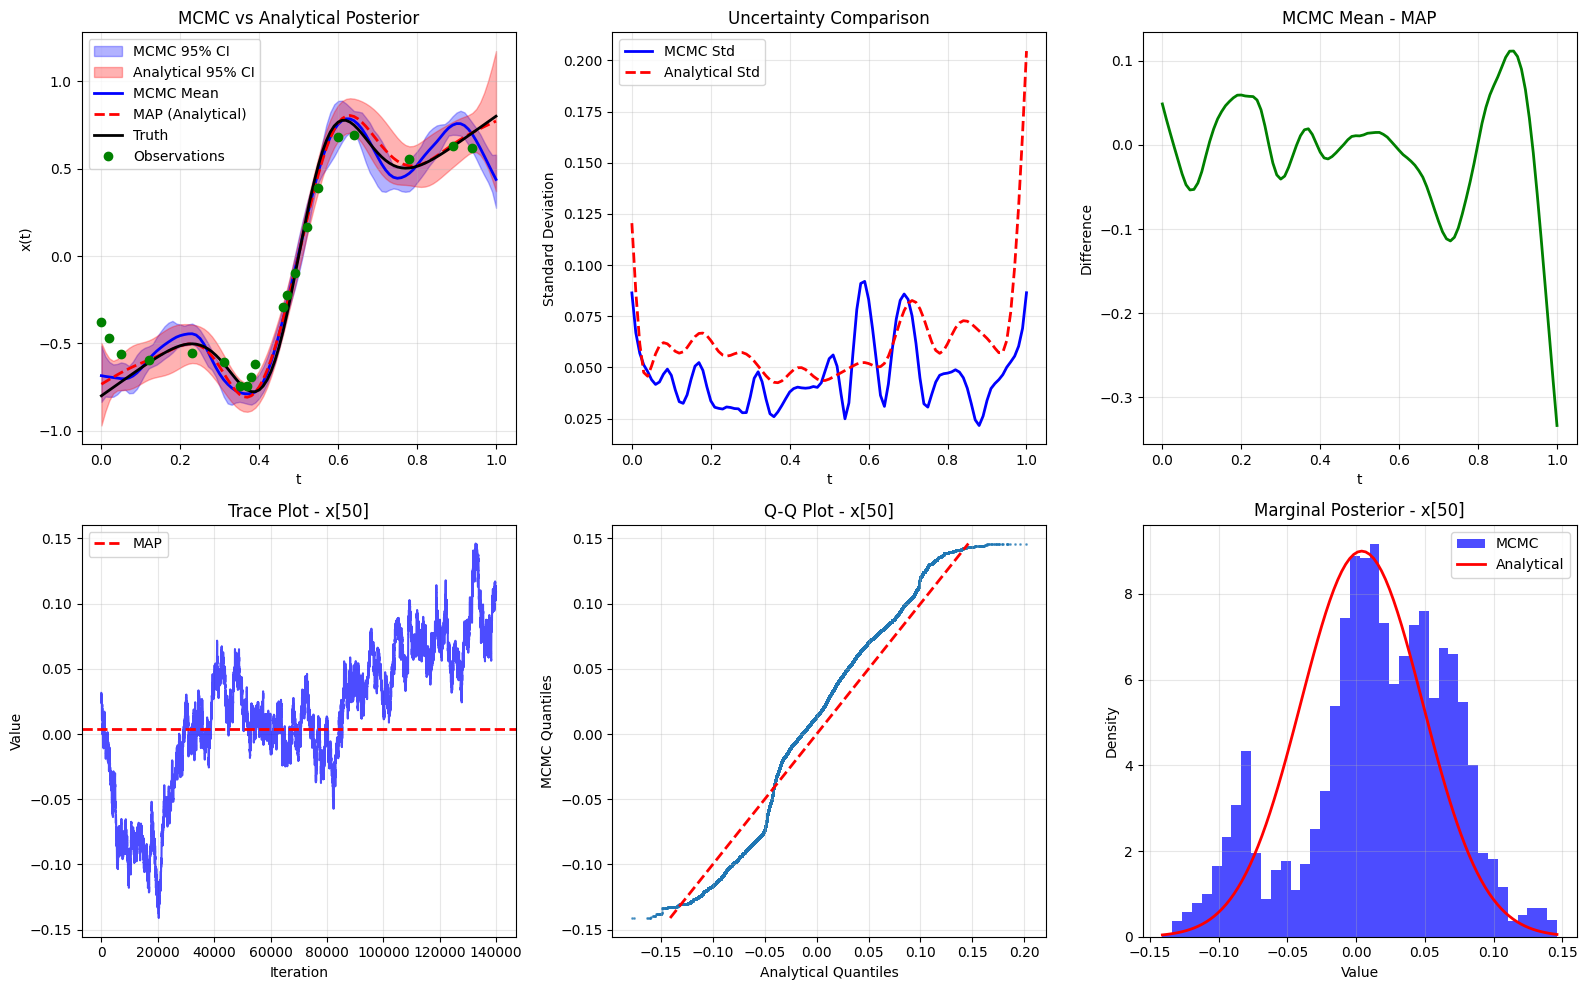

\n============================================================
MCMC vs ANALYTICAL POSTERIOR COMPARISON
MSE (MCMC):           0.006023
MSE (MAP):            0.001514
Mean absolute diff:   0.048014
Std deviation ratio:  0.774
\nSampling Quality Assessment:
- Mean difference should be small (< 0.01)
- Std ratio should be close to 1.0 (0.9-1.1)
- Q-Q plot should be close to diagonal
⚠ MCMC may need more samples or better tuning


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, inv
import time

np.random.seed(20)

def log_posterior(x, forward_op, y_obs, L, sigma, gamma):
    """Compute log posterior density"""
    g_x = forward_op(x)
    residual = y_obs - g_x
    data_term = -0.5 * (1/sigma**2) * np.dot(residual, residual)
    
    Lx = L @ x
    prior_term = -0.5 * (1/gamma**2) * np.dot(Lx, Lx)
    
    return data_term + prior_term

def mcmc_with_jacobian(forward_op, y_obs, L, sigma, gamma, jacobian_matrix, x_init, 
                      n_samples=2000, proposal_scale=0.05):
    """
    Simple MCMC with analytical Jacobian for proposal
    """
    print("Starting MCMC with analytical Jacobian...")
    start_time = time.time()
    
    n_params = len(x_init)
    
    # Compute proposal covariance using Jacobian (A matrix)
    A = jacobian_matrix
    JtJ_diag = np.sum(A**2, axis=0)  # Diagonal of A^T A
    LtL_diag = np.sum(L**2, axis=0)  # Approximate diagonal of L^T L
    
    precision_diag = (1/sigma**2) * JtJ_diag + (1/gamma**2) * LtL_diag
    proposal_cov = proposal_scale / (precision_diag + 1e-12)
    
    # Initialize storage
    samples = np.zeros((n_samples, n_params))
    current_x = x_init.copy()
    current_log_post = log_posterior(current_x, forward_op, y_obs, L, sigma, gamma)
    
    n_accepted = 0
    
    for i in range(n_samples):
        # Generate proposal
        proposal = current_x + np.sqrt(proposal_cov) * np.random.randn(n_params)
        
        # Evaluate log posterior
        proposal_log_post = log_posterior(proposal, forward_op, y_obs, L, sigma, gamma)
        
        # Metropolis acceptance
        log_alpha = proposal_log_post - current_log_post
        
        if np.log(np.random.rand()) < log_alpha:
            current_x = proposal
            current_log_post = proposal_log_post
            n_accepted += 1
        
        samples[i, :] = current_x
        
        if i % 500 == 0:
            print(f"Iteration {i}/{n_samples}")
    
    elapsed_time = time.time() - start_time
    acceptance_rate = n_accepted / n_samples
    
    print(f"MCMC completed in {elapsed_time:.2f} seconds")
    print(f"Acceptance rate: {acceptance_rate:.3f}")
    
    # Remove burn-in (30%)
    burn_in = int(0.3 * n_samples)
    samples_burned = samples[burn_in:, :]
    
    return samples_burned

def compute_analytical_posterior(A, y_obs, L, sigma, gamma):
    """
    Compute analytical MAP estimate and posterior covariance for linear case
    """
    print("Computing analytical posterior...")
    
    # Posterior precision matrix
    posterior_precision = (1/sigma**2) * (A.T @ A) + (1/gamma**2) * (L.T @ L)
    
    # MAP estimate (posterior mean)
    x_map = np.linalg.solve(posterior_precision, (1/sigma**2) * (A.T @ y_obs))
    
    # Posterior covariance
    posterior_cov = inv(posterior_precision)
    
    return x_map, posterior_cov

def plot_mcmc_vs_analytical(t, samples, xtrue, y_obs, t_obs, x_map, posterior_cov):
    """Plot MCMC results vs analytical posterior"""
    
    # MCMC statistics
    x_mean_mcmc = np.mean(samples, axis=0)
    x_std_mcmc = np.std(samples, axis=0)
    x_lower_mcmc = np.percentile(samples, 2.5, axis=0)
    x_upper_mcmc = np.percentile(samples, 97.5, axis=0)
    
    # Analytical statistics
    x_std_analytical = np.sqrt(np.diag(posterior_cov))
    x_lower_analytical = x_map - 1.96 * x_std_analytical
    x_upper_analytical = x_map + 1.96 * x_std_analytical
    
    plt.figure(figsize=(16, 10))
    
    # 1. Reconstruction comparison
    plt.subplot(2, 3, 1)
    plt.fill_between(t, x_lower_mcmc, x_upper_mcmc, alpha=0.3, color='blue', label='MCMC 95% CI')
    plt.fill_between(t, x_lower_analytical, x_upper_analytical, alpha=0.3, color='red', label='Analytical 95% CI')
    plt.plot(t, x_mean_mcmc, 'b-', linewidth=2, label='MCMC Mean')
    plt.plot(t, x_map, 'r--', linewidth=2, label='MAP (Analytical)')
    plt.plot(t, xtrue, 'k-', linewidth=2, label='Truth')
    plt.plot(t_obs, y_obs, 'go', markersize=6, label='Observations')
    plt.legend()
    plt.title('MCMC vs Analytical Posterior')
    plt.xlabel('t')
    plt.ylabel('x(t)')
    plt.grid(True, alpha=0.3)
    
    # 2. Uncertainty comparison
    plt.subplot(2, 3, 2)
    plt.plot(t, x_std_mcmc, 'b-', linewidth=2, label='MCMC Std')
    plt.plot(t, x_std_analytical, 'r--', linewidth=2, label='Analytical Std')
    plt.legend()
    plt.title('Uncertainty Comparison')
    plt.xlabel('t')
    plt.ylabel('Standard Deviation')
    plt.grid(True, alpha=0.3)
    
    # 3. Mean difference
    plt.subplot(2, 3, 3)
    mean_diff = x_mean_mcmc - x_map
    plt.plot(t, mean_diff, 'g-', linewidth=2)
    plt.title('MCMC Mean - MAP')
    plt.xlabel('t')
    plt.ylabel('Difference')
    plt.grid(True, alpha=0.3)
    
    # 4. Trace plot
    plt.subplot(2, 3, 4)
    mid_comp = len(x_mean_mcmc) // 2
    plt.plot(samples[:, mid_comp], alpha=0.7, color='blue')
    plt.axhline(y=x_map[mid_comp], color='red', linestyle='--', linewidth=2, label='MAP')
    plt.legend()
    plt.title(f'Trace Plot - x[{mid_comp}]')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    
    # 5. Q-Q plot for normality check
    plt.subplot(2, 3, 5)
    # Compare MCMC samples to analytical normal distribution
    theoretical_samples = np.random.multivariate_normal(x_map, posterior_cov, len(samples))
    mcmc_flat = samples[:, mid_comp]
    analytical_flat = theoretical_samples[:, mid_comp]
    
    # Sort both for Q-Q plot
    mcmc_sorted = np.sort(mcmc_flat)
    analytical_sorted = np.sort(analytical_flat)
    
    plt.scatter(analytical_sorted, mcmc_sorted, alpha=0.6, s=1)
    plt.plot([mcmc_sorted.min(), mcmc_sorted.max()], 
             [mcmc_sorted.min(), mcmc_sorted.max()], 'r--', linewidth=2)
    plt.title(f'Q-Q Plot - x[{mid_comp}]')
    plt.xlabel('Analytical Quantiles')
    plt.ylabel('MCMC Quantiles')
    plt.grid(True, alpha=0.3)
    
    # 6. Marginal posterior comparison
    plt.subplot(2, 3, 6)
    plt.hist(samples[:, mid_comp], bins=40, density=True, alpha=0.7, 
             color='blue', label='MCMC')
    
    # Overlay analytical normal distribution
    x_range = np.linspace(samples[:, mid_comp].min(), samples[:, mid_comp].max(), 100)
    analytical_pdf = (1/np.sqrt(2*np.pi*posterior_cov[mid_comp, mid_comp])) * \
                     np.exp(-0.5 * (x_range - x_map[mid_comp])**2 / posterior_cov[mid_comp, mid_comp])
    plt.plot(x_range, analytical_pdf, 'r-', linewidth=2, label='Analytical')
    
    plt.legend()
    plt.title(f'Marginal Posterior - x[{mid_comp}]')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison statistics
    print(f"\\n{'='*60}")
    print("MCMC vs ANALYTICAL POSTERIOR COMPARISON")
    print(f"{'='*60}")
    
    mse_mcmc = np.mean((x_mean_mcmc - xtrue)**2)
    mse_map = np.mean((x_map - xtrue)**2)
    mean_abs_diff = np.mean(np.abs(x_mean_mcmc - x_map))
    std_ratio = np.mean(x_std_mcmc / x_std_analytical)
    
    print(f"MSE (MCMC):           {mse_mcmc:.6f}")
    print(f"MSE (MAP):            {mse_map:.6f}")
    print(f"Mean absolute diff:   {mean_abs_diff:.6f}")
    print(f"Std deviation ratio:  {std_ratio:.3f}")
    
    # Check if MCMC is sampling correctly
    print(f"\\nSampling Quality Assessment:")
    print(f"- Mean difference should be small (< 0.01)")
    print(f"- Std ratio should be close to 1.0 (0.9-1.1)")
    print(f"- Q-Q plot should be close to diagonal")
    
    if mean_abs_diff < 0.01 and 0.9 < std_ratio < 1.1:
        print(f"✓ MCMC is sampling correctly from analytical posterior!")
    else:
        print(f"⚠ MCMC may need more samples or better tuning")

# =============================================================================
# Main execution
# =============================================================================

# Problem setup
n = 100
t = np.linspace(0, 1, n+1)
n_obs = 20
obs_indices = np.random.choice(n+1, n_obs, replace=False)
t_obs = t[obs_indices]

# Forward operator setup
beta = 0.05
a = (1/np.sqrt(2*np.pi*beta**2)) * np.exp(-0.5*(1/beta**2)*t**2)
A_full = (1/n) * toeplitz(a)
A = A_full[obs_indices, :]  # This is our Jacobian matrix

# Simple forward function
def forward_function(x):
    return A @ x

# True signal and observations
xtrue = 10*(t-0.5)*np.exp(-0.5*1e2*(t-0.5)**2) - 0.8 + 1.6*t
noise = 5
y_true = forward_function(xtrue)
sigma = np.max(np.abs(y_true)) * noise / 100
y_obs = y_true + sigma * np.random.randn(n_obs)

# Prior setup
gamma = 1/n
L_D = (np.diag(np.ones(n+1)) - 
       np.diag(0.5*np.ones(n), 1) - 
       np.diag(0.5*np.ones(n), -1))

L_Dinv = inv(L_D)
Dev = np.sqrt(gamma**2 * np.diag(L_Dinv @ L_Dinv.T))
delta = gamma / Dev[n//2]

L = L_D.copy()
L[0, :] = 0
L[0, 0] = delta
L[-1, :] = 0
L[-1, -1] = delta

# Run MCMC
x_init = np.zeros(n+1)  # Start from zero
samples = mcmc_with_jacobian(
    forward_op=forward_function,
    y_obs=y_obs,
    L=L,
    sigma=sigma,
    gamma=gamma,
    jacobian_matrix=A,  # Pass A as the Jacobian
    x_init=x_init,
    n_samples=200000,
    proposal_scale=0.1
)

# Compute analytical posterior for comparison
x_map, posterior_cov = compute_analytical_posterior(A, y_obs, L, sigma, gamma)

# Plot comprehensive comparison
plot_mcmc_vs_analytical(t, samples, xtrue, y_obs, t_obs, x_map, posterior_cov)